In [ ]:
#default_exp data.datasets.gefcom2012

In [ ]:
%%html
<style> table {float:left} </style>

# GEFCom2012

> Download the GEFCom2012 dataset.

[Tao Hong, Pierre Pinson, Shu Fan, "Global Energy Forecasting Competition 2012", International Journal of Forecasting, Volume 30, Issue 2, 2014.](https://www.sciencedirect.com/science/article/pii/S0169207013000745)

In [ ]:
#export
import os
import re
import logging
import zipfile

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import pandas as pd

from nixtlats.data.datasets.utils import (
    download_file, 
    Info, 
    TimeSeriesDataclass,
    create_calendar_variables,
    create_us_holiday_distance_variables,
)
from nixtlats.data.tsdataset import TimeSeriesDataset

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['font.family'] = 'serif'
FONTSIZE = 22

In [ ]:
#export
class GEFCom2012:
    
    source_url = 'https://www.dropbox.com/s/epj9b57eivn79j7/GEFCom2012.zip?dl=1'
        
    @staticmethod
    def download(directory: str) -> None:
        """Downloads GEFCom2012 Dataset."""
        path = f'{directory}/gefcom2012'
        if not os.path.exists(path):
            download_file(directory=path, 
                          source_url=GEFCom2012.source_url,
                          decompress=True)

# GEFCom2012-L

The GEFCom2012-L dataset was made available as part of a [kaggle competition](https://www.kaggle.com/c/global-energy-forecasting-competition-2012-load-forecasting). 

The competition asked for the creation of hierarchical forecasts for 20 zones and the system. For this purpose the sum of zonal loads should be equal to the system load. The evaluation metric was the Weighted Root Mean Square Error (WRMSE).

The task was to provide two day ahead hourly forecasts for the power generation of seven wind farms. The dataset contains:
- Hourly electricity load history for twenty zones from 2004-01-01 to 2008-06-30 for train.
- Hourly temperature history for eleven weather stations from 2004-01-01 to 2008-06-30 for train.
- List of US holidays.
- Hourly forecast benchmark from 2008-07-01 to 2008-07-07 with evaluation weights.
- Hourly electricity load test history for twenty zones from 2011-01-01 to 2012-07-07.

In [ ]:
#export
class GEFCom2012_L:
    
    @staticmethod
    def load_Y(directory) -> pd.DataFrame:
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Load'
        filepath = f'{path}/Load_history.csv'
        Y_df = pd.read_csv(filepath, sep=',', thousands=',')

        # Parsing temperature data
        Y_df['ds'] = pd.to_datetime(dict(year=Y_df.year, 
                                         month=Y_df.month, 
                                         day=Y_df.day))
        del Y_df['year'], Y_df['month'], Y_df['day']
        Y_df = pd.wide_to_long(Y_df, ['h'], i=['zone_id', 'ds'], j="hour")
        Y_df.reset_index(inplace=True)
        Y_df['tdelta']   = pd.to_timedelta(Y_df.hour, unit="h")
        Y_df['ds']       = Y_df['ds'] + Y_df['tdelta']
        del Y_df['tdelta'], Y_df['hour']
        Y_df.rename(columns={'zone_id': 'unique_id', 'h': 'y'}, inplace=True)
        #Y_df['y'] = pd.to_numeric(Y_df['y'], errors='coerce')
        return Y_df
    
    @staticmethod
    def load_X(directory) -> pd.DataFrame:
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Load'
        filepath = f'{path}/temperature_history.csv'
        X_df = pd.read_csv(filepath, sep=',')

        # Parsing temperature data
        X_df['ds'] = pd.to_datetime(dict(year=X_df.year, 
                                         month=X_df.month, 
                                         day=X_df.day))
        del X_df['year'], X_df['month'], X_df['day']
        X_df = pd.wide_to_long(X_df, ['h'], i=['station_id', 'ds'], j="hour")
        X_df.reset_index(inplace=True)
        X_df['tdelta']   = pd.to_timedelta(X_df.hour, unit="h")
        X_df['ds']       = X_df['ds'] + X_df['tdelta']
        del X_df['tdelta'], X_df['hour']
        X_df['station_id'] = 'station_' + X_df['station_id'].astype(str)

        X_df = X_df.pivot(index='ds', columns='station_id', values='h').reset_index('ds')
        X_df.reset_index(drop=True, inplace=True)
        X_df = create_calendar_variables(X_df=X_df)
        X_df = create_us_holiday_distance_variables(X_df=X_df)        
        return X_df
    
    @staticmethod
    def load_benchmark(directory) -> pd.DataFrame:
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Load'
        filepath = f'{path}/Load_benchmark.csv'
        benchmark_df = pd.read_csv(filepath, sep=',')
        
        # Parsing benchmark data
        benchmark_df['ds'] = pd.to_datetime(dict(year=benchmark_df.year, 
                                                 month=benchmark_df.month, 
                                                 day=benchmark_df.day))
        del benchmark_df['year'], benchmark_df['month'], benchmark_df['day'], benchmark_df['id']
        benchmark_df.rename(columns={'zone_id': 'unique_id'}, inplace=True)

        benchmark_df = pd.wide_to_long(benchmark_df, ['h'], i=['unique_id', 'ds'], j="hour")
        benchmark_df.reset_index(inplace=True)

        benchmark_df['tdelta']   = pd.to_timedelta(benchmark_df.hour, unit="h")
        benchmark_df['ds']       = benchmark_df['ds'] + benchmark_df['tdelta']
        del benchmark_df['tdelta'], benchmark_df['hour']
        benchmark_df.rename(columns={'h': 'y_hat'}, inplace=True)
        return benchmark_df
    
    @staticmethod
    def load(directory) -> Tuple[pd.DataFrame,
                                 pd.DataFrame,
                                 pd.DataFrame]:
        
        GEFCom2012.download(directory)
        
        Y_df = GEFCom2012_L.load_Y(directory)
        X_df = GEFCom2012_L.load_X(directory)
        benchmark_df = GEFCom2012_L.load_benchmark(directory)
        return Y_df, X_df, benchmark_df

In [ ]:
Y_df, X_df, benchmark_df = GEFCom2012_L.load('data')
Y_df.head()

100%|██████████| 11.6M/11.6M [00:00<00:00, 14.1MiB/s]
INFO:nixtla.data.datasets.utils:Successfully downloaded GEFCom2012.zip?dl=1, 11630887, bytes.
INFO:nixtla.data.datasets.utils:Decompressing zip file...
INFO:nixtla.data.datasets.utils:Successfully decompressed data/gefcom2012/GEFCom2012.zip?dl=1


,unique_id,ds,y
0,1,2004-01-01 01:00:00,16853.0
1,1,2004-01-01 02:00:00,16450.0
2,1,2004-01-01 03:00:00,16517.0
3,1,2004-01-01 04:00:00,16873.0
4,1,2004-01-01 05:00:00,17064.0


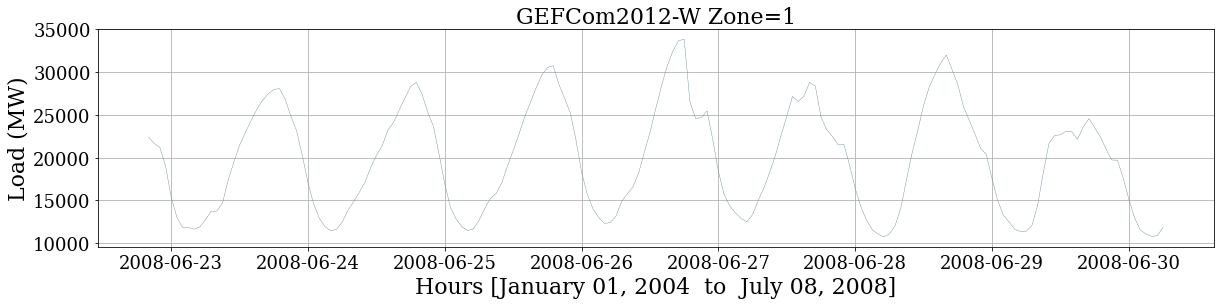

In [ ]:
Y_df, X_df, benchmark_df = GEFCom2012_L.load(directory='data')
Y_df = Y_df[Y_df.unique_id==1]

ds = Y_df.ds.values[-365:]
y_true = Y_df.y.values[-365:]

x_plot = Y_df.ds.values
x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y')
x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y')
x_axis_str = f'Hours [{x_plot_min}  to  {x_plot_max}]'
y_axis_str = 'Load (MW)'

fig = plt.figure(figsize=(20, 4))
fig.tight_layout()
ax0 = plt.subplot2grid((1,1),(0, 0))
axs = [ax0]

axs[0].plot(ds, y_true, color='#628793', linewidth=0.4, label='true')
axs[0].tick_params(labelsize=FONTSIZE-4)
axs[0].set_xlabel(x_axis_str, fontsize=FONTSIZE)
axs[0].set_ylabel(y_axis_str, fontsize=FONTSIZE)
plt.title('GEFCom2012-W Zone=1', fontsize=FONTSIZE)
plt.grid()
plt.show()

# GEFCom2012-W

The GEFCom2012-W dataset was made available as part of a [kaggle competition](https://www.kaggle.com/c/GEF2012-wind-forecasting/overview).

The task was to provide two day ahead hourly forecasts for the power generation of seven wind farms. The dataset contains:
- Hourly wind power history for the seven farms from 2009-07-01 to 2010-12-31 for train.
- Two days ahead wind forecasts for the seven farms from 2009-07-01 to 2012-06-26 for train.
- Hourly wind power history for the seven farms from 2011-01-01 to 2012-06-28 for test.
- Naive forecast benchmark from 2011-01-01 to 2012-06-28.

In [ ]:
#export
class GEFCom2012_W:
    
    train_start = '2009-07-01 00:00:00'
    train_end   = '2010-12-31 23:00:00'
        
    test_start  = '2011-01-01 01:00:00'
    test_end    = '2012-06-28 12:00:00'
    
    @staticmethod
    def load_benchmark(directory):
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Wind'
        filepath = f'{path}/benchmark.csv'
        benchmark_df = pd.read_csv(filepath, sep=',')

        benchmark_df['ds'] = pd.to_datetime(benchmark_df.date, format='%Y%m%d%H')
        del benchmark_df['date']
        benchmark_df = pd.wide_to_long(benchmark_df, ['wp'], i='ds', j="unique_id")
        benchmark_df.reset_index(inplace=True)
        return benchmark_df    
    
    @staticmethod
    def load_Y(directory):
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Wind'
        yfilepath = f'{path}/train.csv'

        # Read and parse Y data
        Y_df = pd.read_csv(yfilepath, sep='\t')
        Y_df['ds'] = pd.date_range(start=GEFCom2012_W.train_start,
                                   end=GEFCom2012_W.train_end, freq='H')
        del Y_df['date']
        Y_df = pd.wide_to_long(Y_df, ['wp'], i='ds', j="unique_id")
        Y_df.reset_index(inplace=True)
        return Y_df
    
    @staticmethod
    def load_X_group(directory, group):
        # Meta data
        path = f'{directory}/gefcom2012/GEFCOM2012_Data/Wind'
        xfilepath = f'{path}/windforecasts_wf{group}.csv'
        X_df = pd.read_csv(xfilepath, sep=',')

        # Create ds associated to each forecast from forecast creation date
        X_df['date']     = X_df.date.astype(str)
        X_df['fcd']      = pd.to_datetime(X_df.date, format='%Y%m%d%H')
        X_df['tdelta']   = pd.to_timedelta(X_df.hors, unit="h")
        X_df['ds']       = X_df['fcd'] + X_df['tdelta']

        # Separate forecasts by lead time
        X_lead12_df = X_df[(X_df.hors>0)  & (X_df.hors<=12)].reset_index(drop=True)
        X_lead24_df = X_df[(X_df.hors>12) & (X_df.hors<=24)].reset_index(drop=True)
        X_lead36_df = X_df[(X_df.hors>24) & (X_df.hors<=36)].reset_index(drop=True)
        X_lead48_df = X_df[(X_df.hors>36) & (X_df.hors<=48)].reset_index(drop=True)
        del X_df

        # Cleaning auxiliary variables and reconstructing X_df
        X_df = pd.DataFrame({'ds': pd.date_range(start='2009-07-01 01:00:00',
                                                 end=GEFCom2012_W.test_end, freq='H')})
        for lead, df in zip(['_lead12', '_lead24', '_lead36', '_lead48'], \
                            [X_lead12_df, X_lead24_df, X_lead36_df, X_lead48_df]):
            df.drop(['fcd', 'tdelta', 'date', 'hors'], axis=1, inplace=True)
            df.columns = [f'u{lead}', f'v{lead}', f'ws{lead}', f'wd{lead}', 'ds'] 
            X_df = X_df.merge(df, on='ds', how='left')

        # Removing nans in hierarchical fashion (priority to shorter lead forecasts)
        for var in ['u', 'v', 'ws', 'wd']:
            X_df[var] = X_df[f'{var}_lead12']
            for lead in ['_lead24', '_lead36', '_lead48']:
                X_df[var].fillna(X_df[f'{var}{lead}'], inplace=True)

        for var in ['u', 'v', 'ws', 'wd']:
            for lead in ['_lead12', '_lead24', '_lead36', '_lead48']:
                X_df[f'{var}{lead}'].fillna(X_df[var], inplace=True)
            del X_df[var]
        del X_lead12_df, X_lead24_df, X_lead36_df, X_lead48_df
        X_df['unique_id'] = group
        return X_df
    
    @staticmethod
    def load(directory: str) -> Tuple[pd.DataFrame,
                                      pd.DataFrame,
                                      pd.DataFrame]:
        GEFCom2012.download(directory)
        
        Y_df = GEFCom2012_W.load_Y(directory)
        X_df_list = [GEFCom2012_W.load_X_group(directory, group) for group in range(1,8)]
        X_df = pd.concat(X_df_list)
        
        benchmark_df = GEFCom2012_W.load_benchmark(directory)
        return Y_df, X_df, benchmark_df

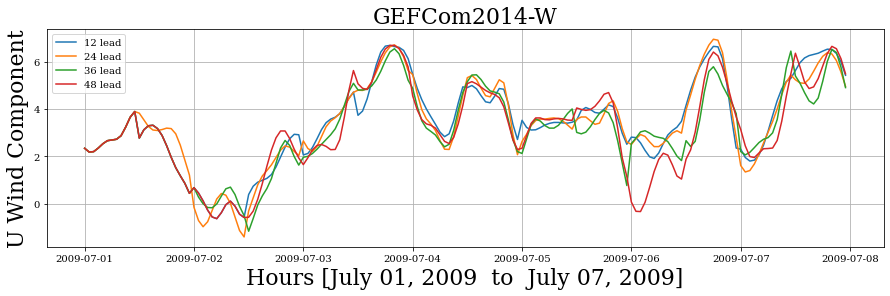

In [ ]:
Y_df, X_df, benchmark_df = GEFCom2012_W.load(directory='data')
Y_df = Y_df[:168]
X_df = X_df[:168]

fig = plt.figure(figsize=(15, 4))

x_plot = Y_df.ds.values
x_plot_min = pd.to_datetime(x_plot.min()).strftime('%B %d, %Y')
x_plot_max = pd.to_datetime(x_plot.max()).strftime('%B %d, %Y')
x_axis_str = f'Hours [{x_plot_min}  to  {x_plot_max}]'
y_axis_str = 'U Wind Component'

plt.plot(x_plot, X_df.u_lead12, label='12 lead')
plt.plot(x_plot, X_df.u_lead24, label='24 lead')
plt.plot(x_plot, X_df.u_lead36, label='36 lead')
plt.plot(x_plot, X_df.u_lead48, label='48 lead')
plt.xlabel(x_axis_str, fontsize=FONTSIZE)
plt.ylabel(y_axis_str, fontsize=FONTSIZE)
plt.title('GEFCom2014-W', fontsize=FONTSIZE)
plt.legend()
plt.grid()
plt.show()

# GEFCom2012-W references
Forecasting Method                                                                                | 48H ahead RMSE
:-----------------------------------------------------------------------------------------------: | :-------: 
[ALL-CF](https://ieeexplore.ieee.org/abstract/document/7497013) [3]                               | 0.14564   | 
[GBM + K-Means + LR](https://www.sciencedirect.com/science/article/abs/pii/S0169207013000836) [2] | 0.14567   |
[KNN](https://www.sciencedirect.com/science/article/abs/pii/S0169207013000848) [1]                | 0.1472    |
[SGCRF](https://ieeexplore.ieee.org/abstract/document/6760016/) [4]                               | 0.1488    |
[LSBRT](https://ieeexplore.ieee.org/abstract/document/7579134/) [5]                               | 0.1518    | 
[SDAE-m-m](https://ieeexplore.ieee.org/abstract/document/8240639) [6]                             | 0.154     | 
[S-GP-ENV](https://ieeexplore.ieee.org/abstract/document/7812215) [7]                             | 0.1604    | 
[GP + NN](https://ieeexplore.ieee.org/abstract/document/6606922/)[8]                              | 0.1752    |
Naive Forecast                                                                                    | 0.361     |

1.	[Mangalova E, Agafonov E. Wind power forecasting using the k-nearest neighbors algorithm. International Journal of Forecasting. 2014; 30:402-406](https://www.sciencedirect.com/science/article/abs/pii/S0169207013000848).
2.	[Silva L. A feature engineering approach to wind power forecasting: GEFCom 2012. International Journal of Forecasting. 2014; 30:395-401](https://www.sciencedirect.com/science/article/abs/pii/S0169207013000836).
3.	[Fang S, Chiang H. A high-accuracy wind power forecasting model. IEEE Transactions on Power Systems. 2016; 32:1589-1590](https://ieeexplore.ieee.org/abstract/document/7497013).
4.	[Wytock M, Kolter Z, "Large-scale probabilistic forecasting in energy systems using sparse gaussian conditional random fields," in 52nd IEEE Conference on Decision and Control, (IEEE, 2013), pp. 1019-1024](https://ieeexplore.ieee.org/abstract/document/6760016/).
5.	[Li G, Chiang H. Toward cost-oriented forecasting of wind power generation. IEEE Transactions on Smart Grid. 2016;9:2508-2517](https://ieeexplore.ieee.org/abstract/document/7579134/).
6.	[Yan J, Zhang H, Liu Y, Han S, Li L, Lu Z. Forecasting the high penetration of wind power on multiple scales using multi-to-multi mapping. IEEE Transactions on Power Systems. 2018;33:3276-3284](https://ieeexplore.ieee.org/abstract/document/8240639).
7.	[Fang S, Chiang H. Improving supervised wind power forecasting models using extended numerical weather variables and unlabelled data. IET Renewable Power Generation. 2016;10:1616-1624](https://ieeexplore.ieee.org/abstract/document/7812215).
8.	[Lee D, Baldick R. Short-term wind power ensemble prediction based on Gaussian processes and neural networks. IEEE Transactions on Smart Grid. 2013;5:501-510](https://ieeexplore.ieee.org/abstract/document/6606922/).
9.	[Landry M, Erlinger TP, Patschke D, Varrichio C. Probabilistic gradient boosting machines for GEFCom2014 wind forecasting. International Journal of Forecasting. 2016; 32:1061-1066.](https://www.sciencedirect.com/science/article/pii/S0169207016000145)